In [1]:
import os
import sys

sys.path.insert(0, "../../")

from src.text.epu import EPU
from src.text.utils import generate_continous_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from tqdm import tqdm
from dateutil.parser import parse

In [2]:
parent_dirs = sys.path[0] + "data/text/"
country_dirs = [
    parent_dirs + country for country in os.listdir(parent_dirs)
    if country != ".DS_Store" and "marshall_islands" not in country
]
output_dir = sys.path[0] + "outputs/text/"

In [3]:
def sentiment_analysis(df):

    sid = SentimentIntensityAnalyzer()
    results = []
    with tqdm(total=len(df)) as pbar:
        for news in df.news:
            scores = sid.polarity_scores(str(news))
            results.append(scores)
            pbar.update(1)
    return results

def calculate_sentiment(df):

    df = df[(df.econ == True)].reset_index(drop=True)

    sent_res = sentiment_analysis(df)

    df["score"] = [i["compound"] for i in sent_res]
    df["date"] = df["date"].apply(lambda x: parse(str(x)).date())
    df["date"] = pd.to_datetime(df["date"])
    month_sent = (df.set_index("date")
                    .groupby(pd.Grouper(freq="MS"))[["score"]]
                    .mean()
                    .reset_index())

    return month_sent

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9506/9506 [00:28<00:00, 335.68it/s]


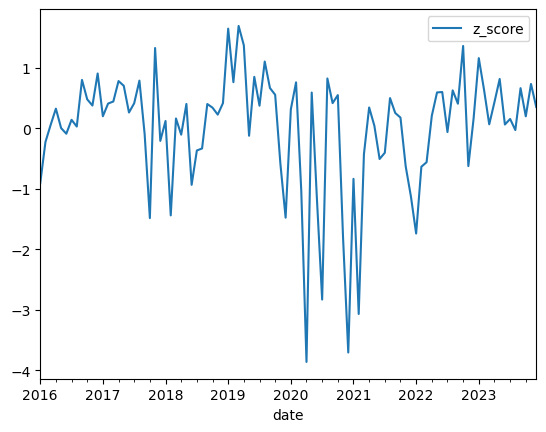

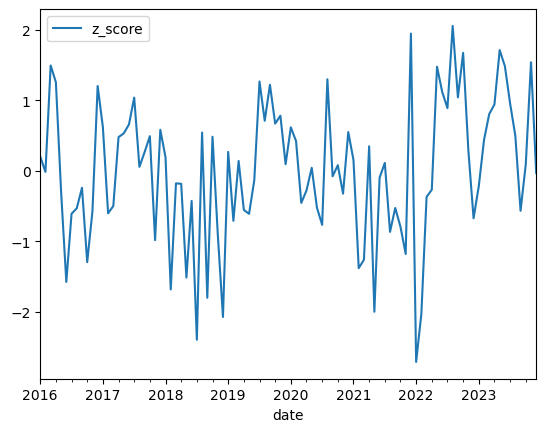

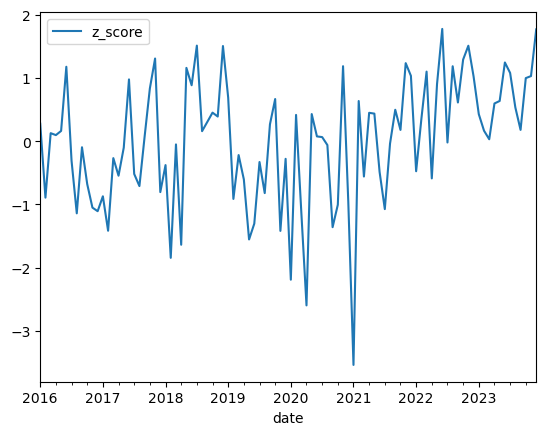

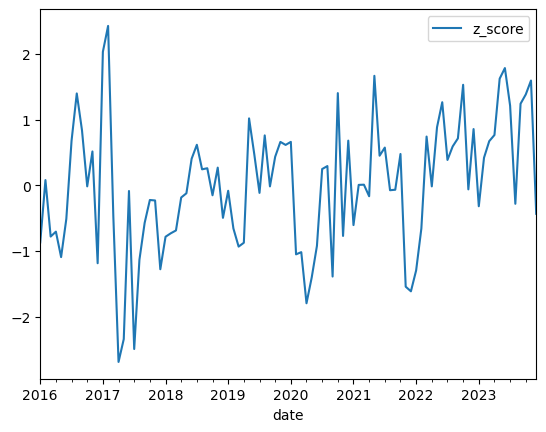

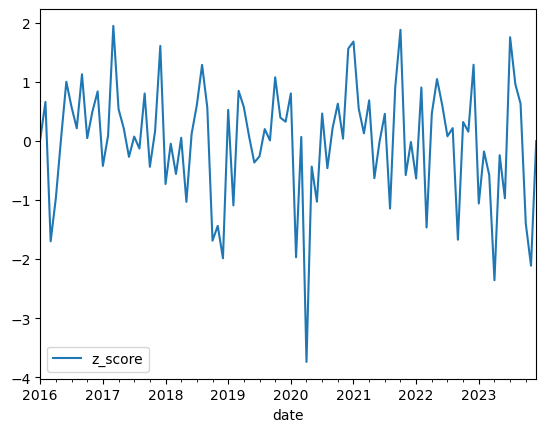

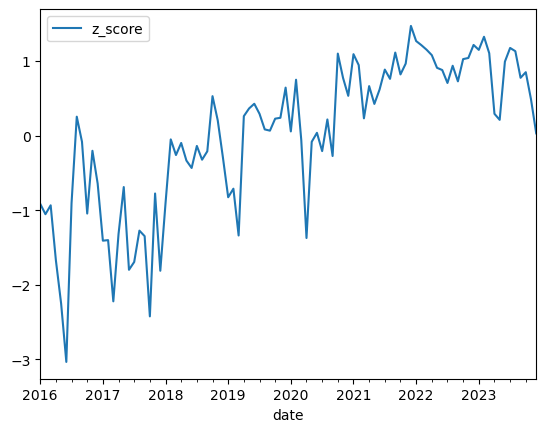

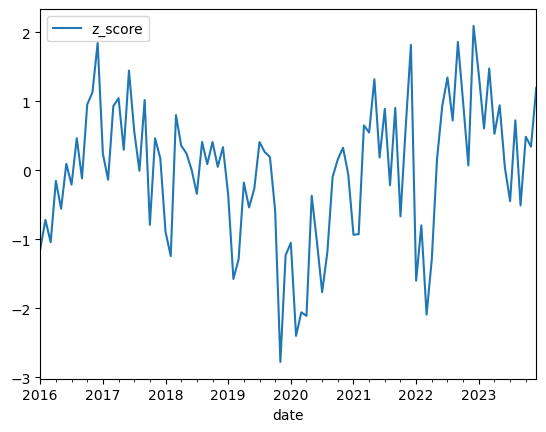

In [5]:
for country in country_dirs:
    country_name = country.split("/")[-1]
    news_dirs = [
        f"{country}/{file}" for file in os.listdir(country) if "news" in file
    ]

    e = EPU(news_dirs, cutoff=None)
    e.get_epu_category(
        subset_condition="date >= '2016-01-01' and date < '2024-01-01'")
    
    dfs = pd.DataFrame()
    for _, df in e.raw_files:
        df_select = df[["news", "date", "econ", "policy"]]
        dfs = pd.concat([dfs, df_select], axis=0).reset_index(drop=True)
    
    sent_df = calculate_sentiment(dfs)

    min_date = str(sent_df.date.min().date())
    max_date = str(sent_df.date.max().date())

    sent_df = generate_continous_df(sent_df, min_date, max_date, freq="MS")
    sent_mean, sent_std = sent_df.score.mean(), sent_df.score.std()
    sent_df["z_score"] = sent_df["score"].apply(lambda x:
                                                (x - sent_mean) / sent_std)
    sent_df.plot(x="date", y=["z_score"])
    
    saved_folder = output_dir + f"{country_name}/sentiment/"
    if not os.path.exists(saved_folder):
        os.mkdir(saved_folder)
    
    sent_df.to_csv(saved_folder + f"{country_name}_sentiment.csv", encoding="utf-8")